## Lab 1.3 - Predicting Real Estate Data in St. Petersburg
We have data from Yandex.Realty classified https://realty.yandex.ru containing real estate listings for apartments in St. Petersburg and Leningrad Oblast from 2016 till the middle of August 2018. In this Lab you'll learn how to apply machine learning algorithms to solve business problems. Accurate price prediction can help to find fraudsters automatically and help Yandex.Realty users to make better decisions when buying and selling real estate.

Using python with machine learning algotithms is the #1 option for prototyping solutions among data scientists today. We'll take a look at it in this lab.

### Main objectives
After successful completion of the lab work students will be able to:
-	Apply machine learning for solving price prediction problem
-   Calculate metrics which can help us find out whether our machine learning model is ready for production

### Tasks
-	Encode dataset
-	Split dataset to train and validation datasets
-	Apply decision tree algorithm to build ML (machine learning) model for price predictions
-   Calculate metrics
-   Try other algorithms and factors to get a better solution 


### 1. Load data with real estate prices

In [1]:
# let's import pandas library and set options to be able to view data right in the browser
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.style as style
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
style.use('fivethirtyeight')
import numpy as np

In [2]:
rent_df_cleaned = pd.read_csv('E2E cleaned_dataset.csv')

In [3]:
rent_df_cleaned.head()

,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,renovation,building_id,last_price_log
0,2015-01-24T00:00:00+03:00,2016-01-19T00:00:00+03:00,20000.0,7,0,1,0,28.0,8.0,20.0,3.0,6719200042030752141,9.903488
1,2015-11-17T00:00:00+03:00,2016-03-04T00:00:00+03:00,24000.0,4,0,2,0,59.0,10.0,35.0,3.0,6719200042030752141,10.085809
2,2015-11-17T00:00:00+03:00,2016-04-24T00:00:00+03:00,18000.0,6,0,1,0,36.0,9.0,17.0,3.0,6719200042030752141,9.798127
3,2016-02-04T00:00:00+03:00,2016-02-28T00:00:00+03:00,18000.0,8,0,1,0,39.0,10.0,18.0,0.0,6719200042030752141,9.798127
4,2016-02-28T00:00:00+03:00,2016-04-02T00:00:00+03:00,19000.0,3,0,1,0,36.0,8.0,18.0,11.0,6719200042030752141,9.852194


In [4]:
rent_df_cleaned.drop(columns=['floor', 'studio', 'kitchen_area', 'living_area', 'building_id'], inplace=True)

In [5]:
rent_df_cleaned.head()

,first_day_exposition,last_day_exposition,last_price,open_plan,rooms,area,renovation,last_price_log
0,2015-01-24T00:00:00+03:00,2016-01-19T00:00:00+03:00,20000.0,0,1,28.0,3.0,9.903488
1,2015-11-17T00:00:00+03:00,2016-03-04T00:00:00+03:00,24000.0,0,2,59.0,3.0,10.085809
2,2015-11-17T00:00:00+03:00,2016-04-24T00:00:00+03:00,18000.0,0,1,36.0,3.0,9.798127
3,2016-02-04T00:00:00+03:00,2016-02-28T00:00:00+03:00,18000.0,0,1,39.0,0.0,9.798127
4,2016-02-28T00:00:00+03:00,2016-04-02T00:00:00+03:00,19000.0,0,1,36.0,11.0,9.852194


In [6]:
len(rent_df_cleaned)

155391

### Create datasets training, testing and a holdout dataset.
We need a holdout dataset to assess the final quality of the algorithm. When several teams create their models based on different models and factors, holdout dataset is used to compare results.
Testing dataset can be used to test models and tune hyperparameters.
Since our model will be used to predict prices for new offers based on the old data, it's a good option to select split by time instead of just random split.

In [7]:
# select all offers added the first 3 months of 2018 as train dataset.
# '&' means 'and' and should be used when both conditions are satisfied
# pay attention that it's better always to put conditions in brackets to embrace the right priority of operations
train_df = rent_df_cleaned[(rent_df_cleaned.first_day_exposition >= '2018-01-01') 
                          & (rent_df_cleaned.first_day_exposition < '2018-04-01')]

In [8]:
len(train_df)

16974

In [9]:
# select all offers added in april and may 2018 as test dataset.
test_df = rent_df_cleaned[(rent_df_cleaned.first_day_exposition >= '2018-04-01') 
                          & (rent_df_cleaned.first_day_exposition < '2018-06-01')]

In [10]:
len(test_df)

14974

In [11]:
# let's use latest data from 2018-06-01 as a hodout dataset to simulate how algorithms would
# behave in production
holdout_df = rent_df_cleaned[rent_df_cleaned.first_day_exposition >= '2018-06-01']

In [12]:
len(holdout_df)

21112

In [13]:
train_df.head()

,first_day_exposition,last_day_exposition,last_price,open_plan,rooms,area,renovation,last_price_log
8,2018-01-05T00:00:00+03:00,2018-01-16T00:00:00+03:00,26000.0,0,1,36.0,0.0,10.165852
24,2018-01-20T00:00:00+03:00,2018-02-28T00:00:00+03:00,17500.0,0,1,32.0,1.0,9.769956
25,2018-02-09T00:00:00+03:00,2018-03-03T00:00:00+03:00,16000.0,0,1,38.0,0.0,9.680344
26,2018-03-19T00:00:00+03:00,2018-04-18T00:00:00+03:00,22000.0,0,1,32.0,0.0,9.998798
27,2018-03-26T00:00:00+03:00,2018-03-30T00:00:00+03:00,20000.0,0,1,32.0,0.0,9.903488


In [14]:
train_df.drop(columns=['first_day_exposition','last_day_exposition','last_price_log' ], inplace=True)
test_df.drop(columns=['first_day_exposition','last_day_exposition', 'last_price_log'], inplace=True)



/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [15]:
train_df.head()

,last_price,open_plan,rooms,area,renovation
8,26000.0,0,1,36.0,0.0
24,17500.0,0,1,32.0,1.0
25,16000.0,0,1,38.0,0.0
26,22000.0,0,1,32.0,0.0
27,20000.0,0,1,32.0,0.0


In [16]:
## Building Decision Tree model

In [17]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [18]:
X_train = train_df.drop('last_price', axis=1)
y_train = train_df['last_price']
X_valid = test_df.drop('last_price', axis=1)
y_valid = test_df['last_price']
y_train= y_train.values.reshape(-1,1)
y_valid= y_valid.values.reshape(-1,1)
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_valid = sc_X.fit_transform(X_valid)
y_train = sc_y.fit_transform(y_train)
y_valid = sc_y.fit_transform(y_valid)

In [19]:
X_train.shape, y_train.shape

((16974, 4), (16974, 1))

In [20]:
tree = DecisionTreeRegressor(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=17)

In [21]:
tree_predictions = tree.predict(X_valid)

In [22]:
tree_predictions[:5]

array([-0.43454727, -0.14274893,  0.68336197, -0.14274893, -0.14274893])

In [23]:
predictions = sc_y.inverse_transform(tree_predictions[:5])
values = test_df['last_price']
for pred, val in zip(predictions,values):
    print("Prediction: {}, True Value {}".format(pred, val))

Prediction: 20570.519993480193, True Value 19000.0
Prediction: 25866.622230494493, True Value 29000.0
Prediction: 40860.428547107906, True Value 45000.0
Prediction: 25866.622230494493, True Value 35000.0
Prediction: 25866.622230494493, True Value 35000.0


In [24]:

print('MAE:', metrics.mean_absolute_error(y_valid, tree_predictions))
print('MSE:', metrics.mean_squared_error(y_valid, tree_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, tree_predictions)))


MAE: 0.3622764602723795
MSE: 0.40126867222258794
RMSE: 0.6334577114714035


In [25]:
##Building linear regression 

In [26]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
print('MAE:', metrics.mean_absolute_error(y_valid, model.predict(X_valid)))
print('MSE:', metrics.mean_squared_error(y_valid, model.predict(X_valid)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, model.predict(X_valid))))

MAE: 0.38499143216286413
MSE: 0.41607838402954517
RMSE: 0.6450413816411666


In [27]:
##Building random forest regressor 

In [28]:
random_forest_model = RandomForestRegressor(n_estimators=10,
                                    bootstrap=0.8,
                                    max_depth=10,
                                    min_samples_split=3,
                                    max_features=1)
random_forest_model.fit(X_train, y_train)
predictions = random_forest_model.predict(X_valid)
print('MAE:', metrics.mean_absolute_error(y_valid, predictions))
print('MSE:', metrics.mean_squared_error(y_valid, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, predictions)))

MAE: 0.36051776113899253
MSE: 0.42237049038634955
RMSE: 0.6499003695847153


<ipython-input-28-ae02bbe15cd1>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_model.fit(X_train, y_train)


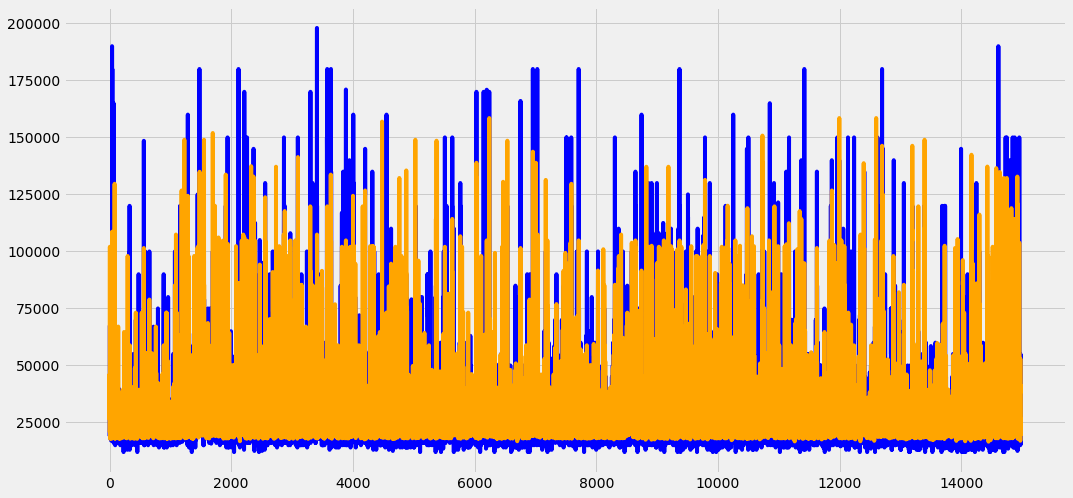

In [29]:
plt.figure(figsize=(16,8))
plt.plot(sc_y.inverse_transform(y_valid),label ='Test', color= 'blue')
plt.plot(sc_y.inverse_transform(predictions), label = 'predict', color = 'orange')
plt.show()

In [30]:
from catboost import CatBoostRegressor
catboost_model = CatBoostRegressor(iterations=1500, 
                                 depth=7,
                                 learning_rate=0.08,
                                 logging_level='Silent',
                                 thread_count=10,
                                 random_seed=27)
# train the model on training dataset
catboost_model.fit(X_train, y_train)
predictions = catboost_model.predict(X_valid)
print('MAE:', metrics.mean_absolute_error(y_valid, predictions))
print('MSE:', metrics.mean_squared_error(y_valid, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, predictions)))

MAE: 0.3781550313872402
MSE: 0.45542299316701224
RMSE: 0.6748503487196345


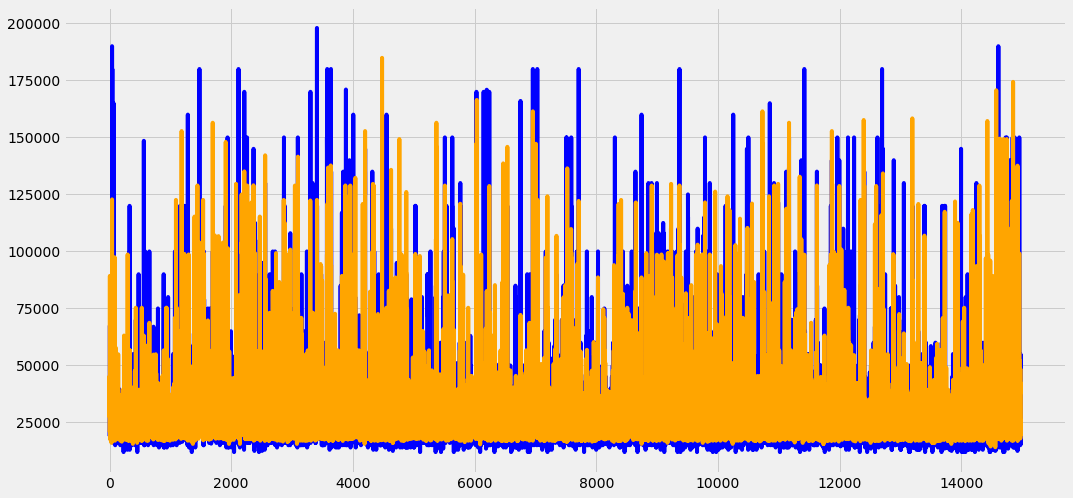

In [31]:
plt.figure(figsize=(16,8))
plt.plot(sc_y.inverse_transform(y_valid),label ='Test', color= 'blue')
plt.plot(sc_y.inverse_transform(predictions), label = 'predict', color = 'orange')
plt.show()

In [32]:
import joblib

In [33]:

joblib.dump(sc_X, 'scaler_x.pkl')
joblib.dump(sc_y, 'scaler_y.pkl')
joblib.dump(random_forest_model, 'random_forest_model.pkl')
joblib.dump(catboost_model, 'catboost_model.pkl')

['catboost_model.pkl']

### Self-control stops
1. Compete with other teams to create the best solution. You can play with factors and algorithm parameters to come up with it.

In [34]:
# Winner: random forest